In [62]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
import pandas as pd
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from matplotlib import pyplot as plt
import yfinance as yf

df = yf.download('TSLA','2016-01-01','2020-01-01')
df.reset_index(inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
train_dates = pd.to_datetime(df['Date'])
print(train_dates)

[*********************100%***********************]  1 of 1 completed
0      2016-01-04
1      2016-01-05
2      2016-01-06
3      2016-01-07
4      2016-01-08
          ...    
1001   2019-12-24
1002   2019-12-26
1003   2019-12-27
1004   2019-12-30
1005   2019-12-31
Name: Date, Length: 1006, dtype: datetime64[ns]


['Open', 'High', 'Low', 'Close', 'Adj Close']


<Axes: >

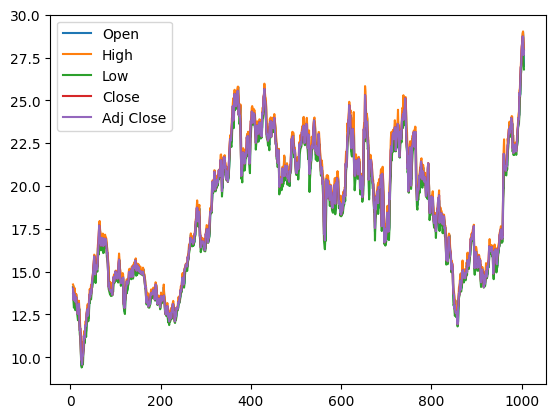

In [50]:
cols = list(df)[1:6]
print(cols)

train_df = df[cols].astype(float)

df_plot = train_df.tail(1000)
df_plot.plot.line()

In [51]:
scaler = StandardScaler()
scaler = scaler.fit(train_df)
train_df_scaled = scaler.transform(train_df)

In [52]:
X_train = []
y_train = []

future_n = 1
past_n = 14

for i in range(past_n, len(train_df_scaled) - future_n + 1):
    X_train.append(train_df_scaled[i - past_n:i, 0:train_df.shape[1]])
    y_train.append(train_df_scaled[i + future_n - 1:i + future_n, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

print(f'TrainX shape == {X_train.shape}')
print(f'TrainY shape == {y_train.shape}')

TrainX shape == (992, 14, 5)
TrainY shape == (992, 1)


In [53]:
model = Sequential()

model.add(LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(y_train.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 14, 64)            17920     
                                                                 
 lstm_25 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_12 (Dropout)        (None, 32)                0         
                                                                 
 dense_12 (Dense)            (None, 1)                 33        
                                                                 
Total params: 30369 (118.63 KB)
Trainable params: 30369 (118.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [54]:
history = model.fit(X_train, y_train, epochs=12, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/10
56/56 [==============================] - 2s 7ms/step - loss: 0.2599 - val_loss: 0.2088
Epoch 2/10
56/56 [==============================] - 0s 5ms/step - loss: 0.0952 - val_loss: 0.0778
Epoch 3/10
56/56 [==============================] - 0s 5ms/step - loss: 0.0720 - val_loss: 0.0432
Epoch 4/10
56/56 [==============================] - 0s 5ms/step - loss: 0.0625 - val_loss: 0.0678
Epoch 5/10
56/56 [==============================] - 0s 5ms/step - loss: 0.0663 - val_loss: 0.0315
Epoch 6/10
56/56 [==============================] - 0s 5ms/step - loss: 0.0575 - val_loss: 0.0520
Epoch 7/10
56/56 [==============================] - 0s 5ms/step - loss: 0.0516 - val_loss: 0.0183
Epoch 8/10
56/56 [==============================] - 0s 5ms/step - loss: 0.0442 - val_loss: 0.0219
Epoch 9/10
56/56 [==============================] - 0s 5ms/step - loss: 0.0429 - val_loss: 0.0191
Epoch 10/10
56/56 [==============================] - 0s 5ms/step - loss: 0.0405 - val_loss: 0.0225


In [69]:
n_future = 90
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
forecast_period_dates = pd.date_range(list(train_dates)[-1], periods=n_future, freq=us_bd).tolist()
forecast = model.predict(X_train[-n_future:])
print(forecast_period_dates)


3/3 [==============================] - 0s 2ms/step
[Timestamp('2019-12-31 00:00:00'), Timestamp('2020-01-02 00:00:00'), Timestamp('2020-01-03 00:00:00'), Timestamp('2020-01-06 00:00:00'), Timestamp('2020-01-07 00:00:00'), Timestamp('2020-01-08 00:00:00'), Timestamp('2020-01-09 00:00:00'), Timestamp('2020-01-10 00:00:00'), Timestamp('2020-01-13 00:00:00'), Timestamp('2020-01-14 00:00:00'), Timestamp('2020-01-15 00:00:00'), Timestamp('2020-01-16 00:00:00'), Timestamp('2020-01-17 00:00:00'), Timestamp('2020-01-21 00:00:00'), Timestamp('2020-01-22 00:00:00'), Timestamp('2020-01-23 00:00:00'), Timestamp('2020-01-24 00:00:00'), Timestamp('2020-01-27 00:00:00'), Timestamp('2020-01-28 00:00:00'), Timestamp('2020-01-29 00:00:00'), Timestamp('2020-01-30 00:00:00'), Timestamp('2020-01-31 00:00:00'), Timestamp('2020-02-03 00:00:00'), Timestamp('2020-02-04 00:00:00'), Timestamp('2020-02-05 00:00:00'), Timestamp('2020-02-06 00:00:00'), Timestamp('2020-02-07 00:00:00'), Timestamp('2020-02-10 00:00:00

<Axes: xlabel='Date', ylabel='Open'>

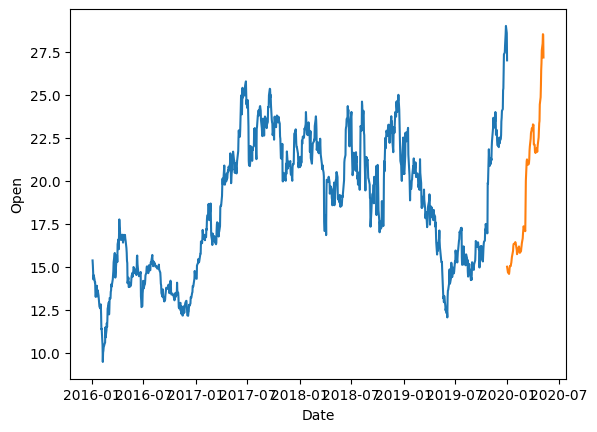

In [70]:
forecast_copies = np.repeat(forecast, train_df.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(forecast_copies)[:,0]

forecast_dates = []
for time_i in forecast_period_dates:
    forecast_dates.append(time_i.date())

df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Open':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])
df['Date']=pd.to_datetime(df['Date'])

original = df[['Date', 'Open']]
original = original.loc[original['Date'] >= '2019-1-1']

sns.lineplot(x=df['Date'], y=df['Open'])
sns.lineplot(x=df_forecast['Date'], y=df_forecast['Open'])

In [ ]:
sns.lineplot(x=df['Date'], y=df['Open'])
sns.lineplot(x=df_forecast['Date'], y=df_forecast['Open'])

[*********************100%***********************]  1 of 1 completed
['Open', 'High', 'Low', 'Close', 'Adj Close']
Epoch 1/12
39/39 - 1s - loss: 0.1704 - val_loss: 0.0295 - 1s/epoch - 33ms/step
Epoch 2/12
39/39 - 0s - loss: 0.0383 - val_loss: 0.1150 - 201ms/epoch - 5ms/step
Epoch 3/12
39/39 - 0s - loss: 0.0429 - val_loss: 0.3140 - 208ms/epoch - 5ms/step
Epoch 4/12
39/39 - 0s - loss: 0.0362 - val_loss: 0.0473 - 216ms/epoch - 6ms/step
Epoch 5/12
39/39 - 0s - loss: 0.0321 - val_loss: 0.3766 - 224ms/epoch - 6ms/step
Epoch 6/12
39/39 - 0s - loss: 0.0304 - val_loss: 1.2612 - 215ms/epoch - 6ms/step
Epoch 7/12
39/39 - 0s - loss: 0.0392 - val_loss: 0.5646 - 220ms/epoch - 6ms/step
Epoch 8/12
39/39 - 0s - loss: 0.0459 - val_loss: 0.0412 - 212ms/epoch - 5ms/step
Epoch 9/12
39/39 - 0s - loss: 0.0306 - val_loss: 0.1392 - 212ms/epoch - 5ms/step
Epoch 10/12
39/39 - 0s - loss: 0.0324 - val_loss: 0.6945 - 216ms/epoch - 6ms/step
Epoch 11/12
39/39 - 0s - loss: 0.0248 - val_loss: 0.0614 - 216ms/epoch - 6ms

/var/folders/dm/qkl8hp4j5338zb36dln1sxlw0000gn/T/ipykernel_89551/678327275.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['Date']=pd.to_datetime(original['Date'])


<Axes: xlabel='Date', ylabel='Open'>

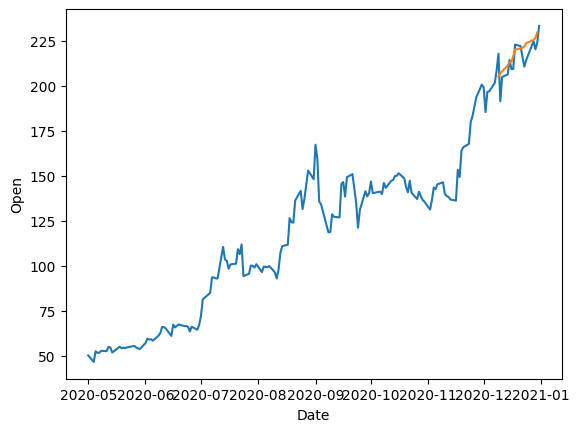

In [48]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

#Read the csv file
df = yf.download('TSLA','2016-01-01','2021-01-01')
df.reset_index(inplace=True)
df['Date'] = pd.to_datetime(df['Date']) #7 columns, including the Date. 

#Separate dates for future plotting
train_dates = pd.to_datetime(df['Date'])


#Variables for training
cols = list(df)[1:6]
#Date and volume columns are not used in training. 
print(cols) #['Open', 'High', 'Low', 'Close', 'Adj Close']

#New dataframe with only training data - 5 columns
df_for_training = df[cols].astype(float)

# df_for_plot=df_for_training.tail(5000)
# df_for_plot.plot.line()

#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)


#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#In this example, the n_features is 5. We will make timesteps = 14 (past days data used for training). 

#Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 14  # Number of past days we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

# print('trainX shape == {}.'.format(trainX.shape))
# print('trainY shape == {}.'.format(trainY.shape))

#In my case, trainX has a shape (12809, 14, 5). 
#12809 because we are looking back 14 days (12823 - 14 = 12809). 
#Remember that we cannot look back 14 days until we get to the 15th day. 
#Also, trainY has a shape (12809, 1). Our model only predicts a single value, but 
#it needs multiple variables (5 in my example) to make this prediction. 
#This is why we can only predict a single day after our training, the day after where our data ends.
#To predict more days in future, we need all the 5 variables which we do not have. 
#We need to predict all variables if we want to do that. 

# define the Autoencoder model

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
# model.summary()


# fit the model
history = model.fit(trainX, trainY, epochs=12, batch_size=32, validation_split=0.01, verbose=2)

#Predicting...
#Libraries that will help us extract only business days in the US.
#Otherwise our dates would be wrong when we look back (or forward).  
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
#Remember that we can only predict one day in future as our model needs 5 variables
#as inputs for prediction. We only have all 5 variables until the last day in our dataset.
n_past = 16
n_days_for_prediction=15  #let us predict past 15 days

predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction, freq=us_bd).tolist()

#Make prediction
prediction = model.predict(trainX[-n_days_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction

#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]


# Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Open':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])


original = df[['Date', 'Open']]
print(original)
original['Date']=pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2020-5-1']

print(original.head())
sns.lineplot(x=original['Date'], y=original['Open'])
sns.lineplot(x=df_forecast['Date'], y=df_forecast['Open'])